## Import and Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Load the merged and clean dataset
data = pd.read_csv("../../data/ethusd_lasso_selected.csv", parse_dates=['time'])

# Print col
print(data.columns)

Index(['time', 'ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'RV_d,t', 'RV_w,t',
       'RV_m,t', 'volume', 'IPNMAT', 'UEMPMEAN', 'USCONS', 'BUSLOANS',
       'AAAFFM'],
      dtype='object')


## Data cleaning
### Features engineering

Since we are focused on the ln RV, we should drop the non ln values

In [2]:
# Drop the non-ln values
data = data.drop(columns=['RV_d,t', 'RV_w,t', 'RV_m,t'])

We also shifted the daily ln returns by 1

In [3]:
import pandas as pd

# Assuming 'data' is your DataFrame and 'time' is already in datetime format

# Set 'time' as the index
data.set_index('time', inplace=True)

# Create lagged variables for log RVs and volume
lag_features = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t']
for feature in lag_features:
    data[f'{feature}-1'] = data[feature].shift(1)
    data[f'{feature}-2'] = data[feature].shift(2)

data['volume_lag_1'] = data['volume'].shift(1)
data['volume_lag_2'] = data['volume'].shift(2)

# Create helper columns for month and year
data['month'] = data.index.month
data['year'] = data.index.year

# Perform a shift within each macroeconomic variable
macro_vars = ['IPNMAT', 'UEMPMEAN', 'USCONS', 'BUSLOANS', 'AAAFFM']
for col in macro_vars:
    data[f'{col}_lag_1'] = data.groupby(['year', 'month'])[col].shift(1)

# Fill the NaN values correctly
data[[f'{col}_lag_1' for col in macro_vars]] = data[[f'{col}_lag_1' for col in macro_vars]].fillna(method='bfill')

# Drop helper columns
data.drop(columns=['month', 'year'], inplace=True)

# Drop rows with any remaining NaN values
data.dropna(inplace=True)


C:\Users\young\AppData\Local\Temp\ipykernel_20420\1717109098.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[[f'{col}_lag_1' for col in macro_vars]] = data[[f'{col}_lag_1' for col in macro_vars]].fillna(method='bfill')


### Train-test split
We are mindful that the data is a time series data, so we will not randomise the data for the train test split. We will run a 80/20 split instead. 

In [4]:
# Split the data into training and testing sets
total_obs = len(data)
train_size = int(0.8 * total_obs)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create the training features, excluding the target variable and non-lagged features
X_train = train_data.drop(columns=['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'volume'] + macro_vars)

# Ensure all columns are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Define the target variable
y_train = train_data['ln_RV_d,t'].apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values in the features or target
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]

# Save the training feature names
trained_features = X_train.columns.copy()

print("Training features:", trained_features)

Training features: Index(['ln_RV_d,t-1', 'ln_RV_d,t-2', 'ln_RV_w,t-1', 'ln_RV_w,t-2',
       'ln_RV_m,t-1', 'ln_RV_m,t-2', 'volume_lag_1', 'volume_lag_2',
       'IPNMAT_lag_1', 'UEMPMEAN_lag_1', 'USCONS_lag_1', 'BUSLOANS_lag_1',
       'AAAFFM_lag_1'],
      dtype='object')


## Random Forest
We will use a RF model to predict the realised variance

### Training the RF model

In [5]:
n_features = X_train.shape[1]

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_features=int(n_features/3)  
)

if X_train.shape[0] == y_train.shape[0]:
    rf_model.fit(X_train, y_train)
else:
    raise ValueError("Error: Inconsistent number of samples. Cannot train the model.")


Creating a one-day-ahead forecast

In [6]:
ln_rv_forecast = rf_model.predict(X_train.iloc[[-1]])[0]

### Updating the training sample
This is done by removing the oldest one and adding the latest one

### Out of sample performance
We will now test our model to see the performance. Do note that our OOS begins in 2019.

In [7]:
forecasts = []

# Use the test_data's index as the forecasting dates.
test_dates = test_data.index
total_iterations = len(test_dates)

# Save the initial training window size.
window_size = X_train.shape[0]

for i, date in enumerate(test_dates):
    # Print the iteration count.
    print(f"Iteration {i+1} of {total_iterations}. Forecasting for date: {date}")
    
    # --- Forecasting Step ---
    # Build the new observation using only data available up to the forecast date.
    # (We copy the last row from X_train to preserve the column structure.)
    new_observation = X_train.iloc[[-1]].copy()
    
    # Update the dynamic columns using historical data up to the forecast date.
    # Log RV variables:
    new_observation['ln_RV_d,t-1'] = ln_rv_forecast
    new_observation['ln_RV_d,t-2'] = data['ln_RV_d,t'].shift(2).asof(date)
    new_observation['ln_RV_w,t-1'] = data['ln_RV_w,t'].asof(date)
    new_observation['ln_RV_w,t-2'] = data['ln_RV_w,t'].shift(2).asof(date)
    new_observation['ln_RV_m,t-1'] = data['ln_RV_m,t'].asof(date)
    new_observation['ln_RV_m,t-2'] = data['ln_RV_m,t'].shift(2).asof(date)

    # Volume lags:
    new_observation['volume_lag_1'] = data['volume_lag_1'].asof(date)
    new_observation['volume_lag_2'] = data['volume_lag_2'].asof(date)  # New training feature

    # Other macroeconomic variables:
    new_observation['IPNMAT_lag_1'] = data['IPNMAT_lag_1'].asof(date)    # New training feature
    new_observation['UEMPMEAN_lag_1'] = data['UEMPMEAN_lag_1'].asof(date)
    new_observation['USCONS_lag_1'] = data['USCONS_lag_1'].asof(date)      # New training feature
    new_observation['BUSLOANS_lag_1'] = data['BUSLOANS_lag_1'].asof(date)  # New training feature
    new_observation['AAAFFM_lag_1'] = data['AAAFFM_lag_1'].asof(date)
    
    # Set the index of the new observation to the current forecast date.
    new_observation.index = [date]
    
    # Forecast the log-realized volatility for the current date.
    ln_rv_forecast = rf_model.predict(new_observation)[0]
    # Convert forecast from log scale.
    rv_forecast = np.exp(ln_rv_forecast)
    forecasts.append(rv_forecast)
    
    # --- Update Step (After Forecasting) ---
    # Obtain the actual target for this date (if available); in a live forecast this would be delayed.
    if date in data.index:
        new_target = data['ln_RV_d,t'].loc[date]
    else:
        # If not available, you could either skip the update or use a fallback (here, we use the forecast).
        new_target = ln_rv_forecast

    # Append the new observation and its corresponding target to the training set.
    X_train = pd.concat([X_train, new_observation])
    y_train = pd.concat([y_train, pd.Series([new_target], index=[date])])
    
    # Maintain a fixed training window by dropping the oldest observations.
    if len(X_train) > window_size:
        X_train = X_train.iloc[-window_size:]
        y_train = y_train.iloc[-window_size:]
    
    # Ensure X_train and y_train are aligned on the same indices.
    common_index = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_index]
    y_train = y_train.loc[common_index]
    
    # Retrain the model using the updated training set.
    rf_model.fit(X_train, y_train)

print("Forecasts:", forecasts)


Iteration 1 of 523. Forecasting for date: 2022-04-30 00:00:00
Iteration 2 of 523. Forecasting for date: 2022-05-01 00:00:00
Iteration 3 of 523. Forecasting for date: 2022-05-02 00:00:00
Iteration 4 of 523. Forecasting for date: 2022-05-03 00:00:00
Iteration 5 of 523. Forecasting for date: 2022-05-04 00:00:00
Iteration 6 of 523. Forecasting for date: 2022-05-05 00:00:00
Iteration 7 of 523. Forecasting for date: 2022-05-06 00:00:00
Iteration 8 of 523. Forecasting for date: 2022-05-07 00:00:00
Iteration 9 of 523. Forecasting for date: 2022-05-08 00:00:00
Iteration 10 of 523. Forecasting for date: 2022-05-09 00:00:00
Iteration 11 of 523. Forecasting for date: 2022-05-10 00:00:00
Iteration 12 of 523. Forecasting for date: 2022-05-11 00:00:00
Iteration 13 of 523. Forecasting for date: 2022-05-12 00:00:00
Iteration 14 of 523. Forecasting for date: 2022-05-13 00:00:00
Iteration 15 of 523. Forecasting for date: 2022-05-14 00:00:00
Iteration 16 of 523. Forecasting for date: 2022-05-15 00:00:00
I

### Saving results to CSV
Using a high end PC, it already takes 10 mins to do the forecast, so to save the trouble of running the code, we saved the results in a CSV

In [11]:
print(len(forecasts))
print(len(test_dates))

# Save forecasts to a DataFrame and then csv
forecast_df = pd.DataFrame(forecasts, index=test_dates[:len(forecasts)], columns=['forecast'])
forecast_df.to_csv("../../results/models/rf_forecast.csv")

523
523


#### RMSFE
We will use RMSFE to evaluate the results

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# The line below will read the forecasts from the csv file, use it if you are not running the entire script
forecasts = pd.read_csv("../../results/models/rf_forecast.csv", index_col=0, parse_dates=True)['forecast']


forecast_dates = test_data.index
forecasts_series = pd.Series(forecasts, index=forecast_dates)

# Extract the actual log-transformed realized variance from your test data
ln_rv_actual = test_data['ln_RV_d,t']

# If your forecasts are in log scale, exponentiate to get the actual scale
actual_rv = np.exp(ln_rv_actual)

# Calculate Error Metrics
mse = mean_squared_error(actual_rv, forecasts_series)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_rv, forecasts_series)
r2 = r2_score(actual_rv, forecasts_series)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000001
Mean Absolute Percentage Error (MAPE): 56.139747%
R² Score: 0.385388


#### Feature Importance
We examined the feature importance of the RF model. We can note that the one day realised variance lag seems to be the most significant, followed by volume and then daily returns.

In [13]:
importances = np.round(rf_model.feature_importances_, 4)
feature_importance_df = pd.DataFrame({
    'Feature': trained_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (impurity based):")
print(feature_importance_df)



Feature Importances (impurity based):
           Feature  Importance
0      ln_RV_d,t-1      0.2689
2      ln_RV_w,t-1      0.2236
3      ln_RV_w,t-2      0.1018
1      ln_RV_d,t-2      0.0983
6     volume_lag_1      0.0682
4      ln_RV_m,t-1      0.0557
5      ln_RV_m,t-2      0.0448
7     volume_lag_2      0.0347
10    USCONS_lag_1      0.0262
12    AAAFFM_lag_1      0.0215
11  BUSLOANS_lag_1      0.0202
9   UEMPMEAN_lag_1      0.0193
8     IPNMAT_lag_1      0.0169


#### Plotting out
We will now plot out a line graph of data. 

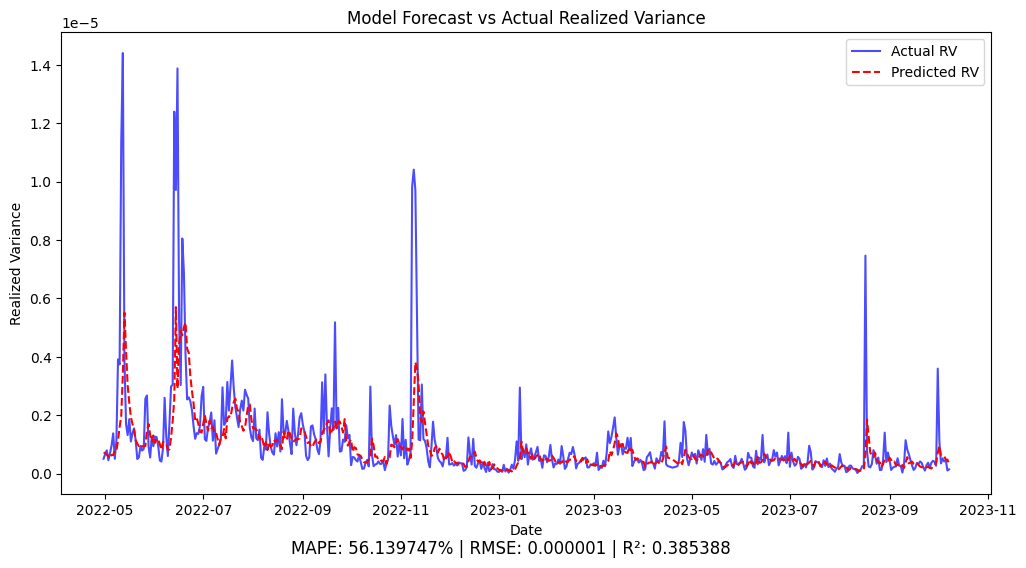

In [14]:

# Plot Actual vs Predicted Realized Variance
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_rv, label="Actual RV", color="blue", alpha=0.7)
plt.plot(forecast_dates, forecasts_series, label="Predicted RV", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("Model Forecast vs Actual Realized Variance")
plt.legend()

# Add Captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)

# Save the plot
plt.savefig('../../results/figures/model_forecast_vs_actual.png')
plt.show()

## HAR
Heterogenous Autoregression (HAR) is a form of autoregression that uses past data to predict the future data. 

We will use the same train test split above

### Reindexing daily and monthly rv

In [15]:
har_df = pd.DataFrame({
    'lag1_log_rv': data['ln_RV_d,t'].shift(1),
    'lag_weekly': data['ln_RV_d,t'].shift(1),
    'lag_monthly': data['ln_RV_d,t'].shift(1),
    'log_daily_rv': data['ln_RV_d,t']
})

# Drop initial missing observations
har_df = har_df.dropna()


### Train test split
We will still be using 80/20

In [16]:
train_df = har_df.iloc[:train_size]
test_df = har_df.iloc[train_size:]

### Training the model

In [21]:
X_train = train_df[['lag1_log_rv', 'lag_weekly', 'lag_monthly']]
y_train = train_df['log_daily_rv']
X_train_const = sm.add_constant(X_train)

# Fit the model
har_model = sm.OLS(y_train, X_train_const).fit()
print(har_model.summary())

forecast_log_rv = har_model.predict(sm.add_constant(X_train.iloc[[-1]], has_constant='add')).iloc[0]

                            OLS Regression Results                            
Dep. Variable:           log_daily_rv   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     4654.
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:34:51   Log-Likelihood:                -2005.4
No. Observations:                2089   AIC:                             4015.
Df Residuals:                    2087   BIC:                             4026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.2374      0.161    -13.858      

### Out of sample performance
Same as RF, we will run a one step ahead OOS forecasting for the trest data

In [ ]:
# Ensure these HAR features match those used in your initial model.
har_features = ['lag1_log_rv', 'lag_weekly', 'lag_monthly']

forecasts = []
test_dates = test_data.index
total_iterations = len(test_dates)
window_size = X_train.shape[0]

for i, date in enumerate(test_dates):
    print(f"Iteration {i+1} of {total_iterations}. Forecasting for date: {date}")
    
    # Build a new observation DataFrame with only the HAR features.
    new_obs = pd.DataFrame(index=[date], columns=har_features)
    
    # Make sure the new observation has the correct data types.
    # Daily lag: for the first iteration, use the previously forecasted value.
    if i == 0:
        new_obs.loc[date, 'lag1_log_rv'] = forecast_log_rv
    else:
        # Get the most recent daily lag using asof.
        value_daily = data['ln_RV_d,t'].shift(1).asof(date)
        if pd.isna(value_daily):
            # Fallback: use the last training observation's daily lag.
            value_daily = X_train.iloc[-1]['lag1_log_rv']
        new_obs.loc[date, 'lag1_log_rv'] = value_daily
    
    # Weekly lag: get from the weekly series.
    value_weekly = data['ln_RV_w,t'].asof(date)
    if pd.isna(value_weekly):
        value_weekly = X_train.iloc[-1]['lag_weekly']
    new_obs.loc[date, 'lag_weekly'] = value_weekly
    
    # Monthly lag: get from the monthly series.
    value_monthly = data['ln_RV_m,t'].asof(date)
    if pd.isna(value_monthly):
        value_monthly = X_train.iloc[-1]['lag_monthly']
    new_obs.loc[date, 'lag_monthly'] = value_monthly
    
    # Convert new_obs to float to ensure numeric types.
    new_obs = new_obs.astype(float)
    
    # Add a constant so the structure matches the fitted model.
    X_new_const = sm.add_constant(new_obs, has_constant='add')
    
    forecast_log_rv = har_model.predict(X_new_const).iloc[0]
    rv_forecast = np.exp(forecast_log_rv)
    forecasts.append(rv_forecast)
    
    # Determine the new target from test_data.
    if date in test_data.index:
        new_target = test_data.loc[date, 'ln_RV_d,t']
    else:
        new_target = forecast_log_rv  # fallback
    
    # Append the new observation and its target to the training sets.
    X_train = pd.concat([X_train, new_obs])
    y_train = pd.concat([y_train, pd.Series(new_target, index=[date])])
    
    # Ensure X_train and y_train are numeric.
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    
    # Keep a fixed training window.
    if len(X_train) > window_size:
        X_train = X_train.iloc[-window_size:]
        y_train = y_train.iloc[-window_size:]
    
    # Align indices and sort.
    common_index = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_index].sort_index()
    y_train = y_train.loc[common_index].sort_index()
    
    # Refit the HAR model using the updated training set.
    X_train_const = sm.add_constant(X_train, has_constant='add')
    har_model = sm.OLS(y_train, X_train_const).fit()

# Save the HAR forecasts with test_dates as index.
forecast_har = pd.DataFrame(forecasts, index=test_dates, columns=['HAR_Forecast'])
forecast_har.to_csv("../../results/models/har_forecast.csv")
print("HAR Forecasts:", forecasts)


Iteration 1 of 523. Forecasting for date: 2022-04-30 00:00:00
Iteration 2 of 523. Forecasting for date: 2022-05-01 00:00:00
Iteration 3 of 523. Forecasting for date: 2022-05-02 00:00:00
Iteration 4 of 523. Forecasting for date: 2022-05-03 00:00:00
Iteration 5 of 523. Forecasting for date: 2022-05-04 00:00:00
Iteration 6 of 523. Forecasting for date: 2022-05-05 00:00:00
Iteration 7 of 523. Forecasting for date: 2022-05-06 00:00:00
Iteration 8 of 523. Forecasting for date: 2022-05-07 00:00:00
Iteration 9 of 523. Forecasting for date: 2022-05-08 00:00:00
Iteration 10 of 523. Forecasting for date: 2022-05-09 00:00:00
Iteration 11 of 523. Forecasting for date: 2022-05-10 00:00:00
Iteration 12 of 523. Forecasting for date: 2022-05-11 00:00:00
Iteration 13 of 523. Forecasting for date: 2022-05-12 00:00:00
Iteration 14 of 523. Forecasting for date: 2022-05-13 00:00:00
Iteration 15 of 523. Forecasting for date: 2022-05-14 00:00:00
Iteration 16 of 523. Forecasting for date: 2022-05-15 00:00:00
I

#### RMSFE

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

forecast_series = forecast_har['HAR_Forecast']
actual_series = test_df['log_daily_rv'].apply(np.exp)

aligned_df = pd.concat([forecast_series, actual_series], axis=1).dropna()
aligned_df.columns = ['forecast', 'actual']

mse = mean_squared_error(aligned_df['actual'], aligned_df['forecast'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(aligned_df['actual'], aligned_df['forecast'])
r2 = r2_score(aligned_df['actual'], aligned_df['forecast'])

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")


Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000001
Mean Absolute Percentage Error (MAPE): 72.442185%
R² Score: 0.401942


#### Plot of HAR


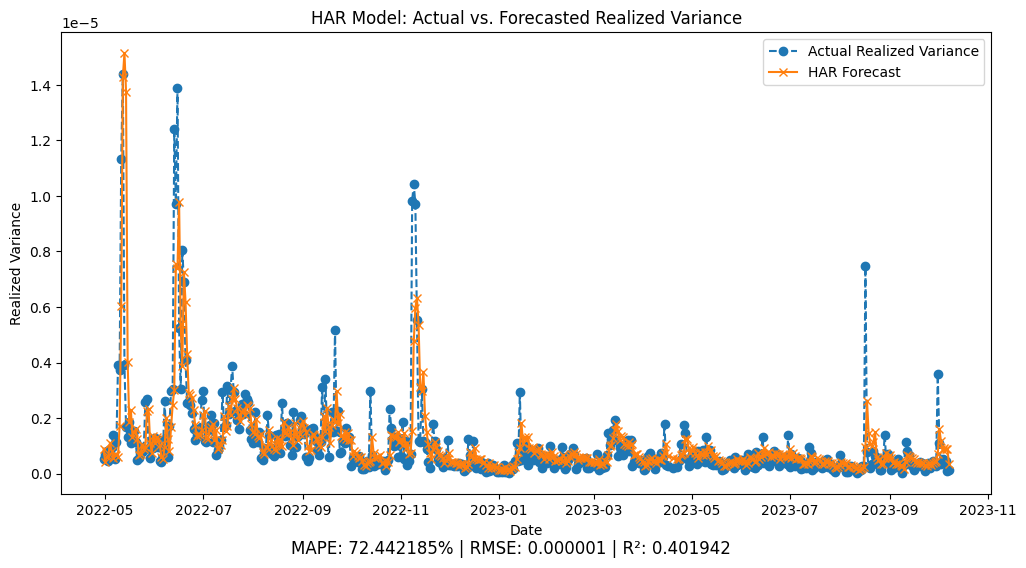

In [25]:
import matplotlib.pyplot as plt

# If forecast_har is saved as a DataFrame with index = test_dates:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.exp(test_data['ln_RV_d,t']), label="Actual Realized Variance", 
         marker='o', linestyle='--')
plt.plot(test_data.index, forecast_har['HAR_Forecast'], label="HAR Forecast", 
         marker='x', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("HAR Model: Actual vs. Forecasted Realized Variance")
plt.legend()
# (Assuming you've computed mape, rmse, r2 earlier)
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('../../results/figures/har_forecast_vs_actual.png')
plt.show()
